<a href="https://colab.research.google.com/github/Pengyu-gis/UrbanSound/blob/main/audio_data_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydub requests
!apt-get install -y ffmpeg

In [ ]:
!pip install librosa

In [ ]:
import pandas as pd
import os
import requests
from pydub import AudioSegment

# Load the dataset
file_path = '/content/newyork.xlsx'
data = pd.read_excel(file_path)

# Create directories for storing downloaded and converted files
os.makedirs('mp3_files', exist_ok=True)
os.makedirs('wav_files', exist_ok=True)

# Function to download MP3 file
def download_mp3(url, file_name):
    response = requests.get(url)
    with open(file_name, 'wb') as file:
        file.write(response.content)

# Function to convert MP3 to WAV
def convert_mp3_to_wav(mp3_file, wav_file):
    sound = AudioSegment.from_mp3(mp3_file)
    sound.export(wav_file, format="wav")

# Iterate over the dataset and download/convert files
for index, row in data.iterrows():
    link = row['link']
    mp3_file_path = f"mp3_files/sound_{index}.mp3"
    wav_file_path = f"wav_files/sound_{index}.wav"

    # Download MP3
    download_mp3(link, mp3_file_path)

    # Convert to WAV
    convert_mp3_to_wav(mp3_file_path, wav_file_path)

    print(f"Downloaded and converted: {mp3_file_path} to {wav_file_path}")


Downloaded and converted: mp3_files/sound_0.mp3 to wav_files/sound_0.wav
Downloaded and converted: mp3_files/sound_1.mp3 to wav_files/sound_1.wav
Downloaded and converted: mp3_files/sound_2.mp3 to wav_files/sound_2.wav
Downloaded and converted: mp3_files/sound_3.mp3 to wav_files/sound_3.wav
Downloaded and converted: mp3_files/sound_4.mp3 to wav_files/sound_4.wav


KeyboardInterrupt: 

## Calculate Spectral Convergence

In [ ]:
!pip install librosa[resample]

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


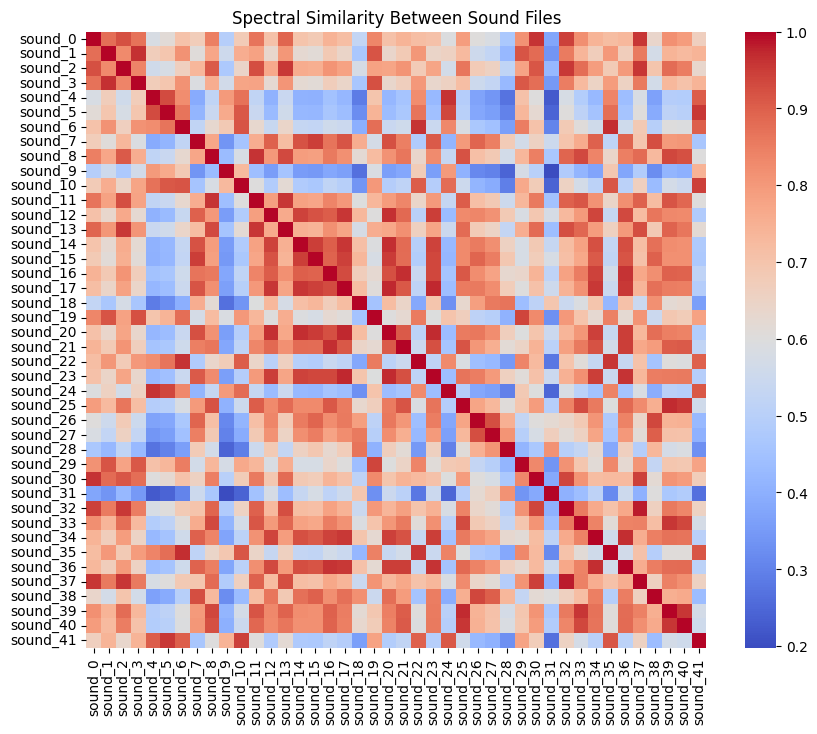

In [ ]:
import soundfile as sf
import numpy as np
import os
import librosa
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract Mel spectrogram from audio file using soundfile and librosa
def extract_mel_spectrogram(file_name, max_length=None):
    audio, sr = sf.read(file_name)  # Read the audio file
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Pad or truncate to max_length if provided
    if max_length:
        if mel_spectrogram_db.shape[1] < max_length:
            pad_width = max_length - mel_spectrogram_db.shape[1]
            mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spectrogram_db = mel_spectrogram_db[:, :max_length]

    return mel_spectrogram_db

# Directory containing WAV files
wav_dir = 'wav_files'

# Extract Mel spectrograms for all WAV files
spectrograms = []
file_names = []
max_len = 0  # Track the maximum length for padding

# First, find the max length of the spectrograms
for index, row in data.iterrows():
    wav_file = os.path.join(wav_dir, f"sound_{index}.wav")
    mel_spectrogram = extract_mel_spectrogram(wav_file)
    max_len = max(max_len, mel_spectrogram.shape[1])  # Find the longest spectrogram

# Now, extract and pad spectrograms
for index, row in data.iterrows():
    wav_file = os.path.join(wav_dir, f"sound_{index}.wav")
    mel_spectrogram = extract_mel_spectrogram(wav_file, max_length=max_len)
    spectrograms.append(mel_spectrogram.flatten())  # Flatten the spectrogram for comparison
    file_names.append(f"sound_{index}")

# Calculate spectral convergence (cosine similarity between Mel spectrograms)
spectrograms = np.array(spectrograms)
similarity_matrix = 1 - cdist(spectrograms, spectrograms, metric='cosine')

# Visualize the similarity matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=file_names, yticklabels=file_names, cmap='coolwarm', annot=False)
plt.title('Spectral Similarity Between Sound Files')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


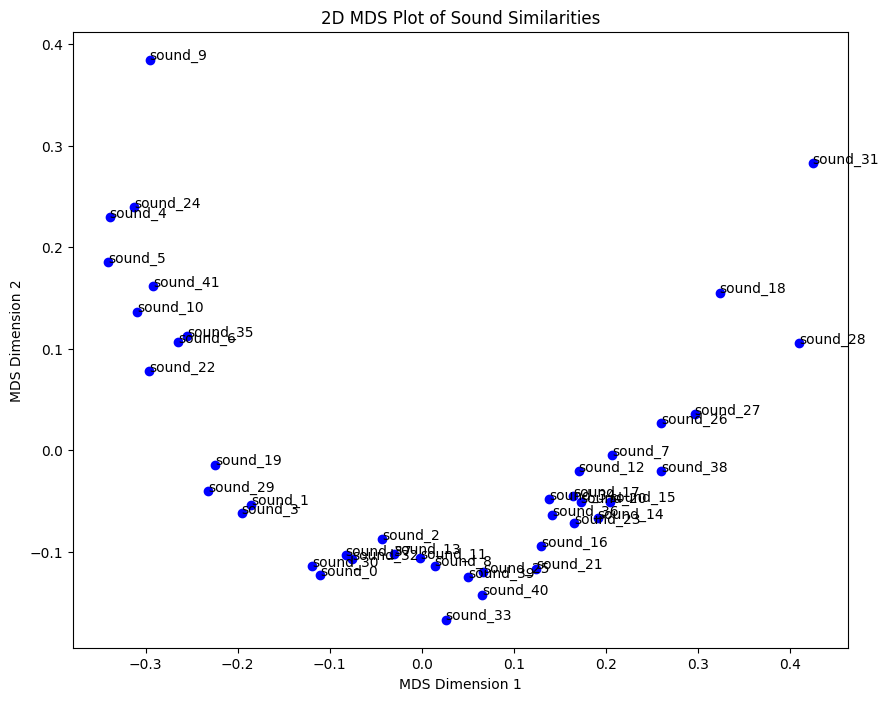

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


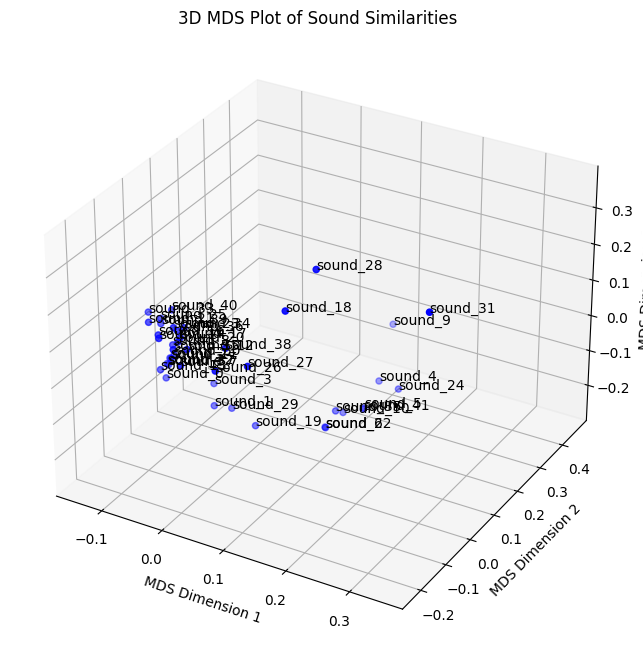

In [ ]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 2D MDS plot
def plot_mds_2d(similarity_matrix, labels):
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_result = mds.fit_transform(1 - similarity_matrix)  # Dissimilarity = 1 - similarity

    plt.figure(figsize=(10, 8))
    plt.scatter(mds_result[:, 0], mds_result[:, 1], c='b', marker='o')

    for i, label in enumerate(labels):
        plt.text(mds_result[i, 0], mds_result[i, 1], label)

    plt.title('2D MDS Plot of Sound Similarities')
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.show()

# 3D MDS plot
def plot_mds_3d(similarity_matrix, labels):
    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
    mds_result = mds.fit_transform(1 - similarity_matrix)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(mds_result[:, 0], mds_result[:, 1], mds_result[:, 2], c='b', marker='o')

    for i, label in enumerate(labels):
        ax.text(mds_result[i, 0], mds_result[i, 1], mds_result[i, 2], label)

    ax.set_title('3D MDS Plot of Sound Similarities')
    ax.set_xlabel('MDS Dimension 1')
    ax.set_ylabel('MDS Dimension 2')
    ax.set_zlabel('MDS Dimension 3')
    plt.show()

# Plotting 2D and 3D MDS
plot_mds_2d(similarity_matrix, file_names)
plot_mds_3d(similarity_matrix, file_names)


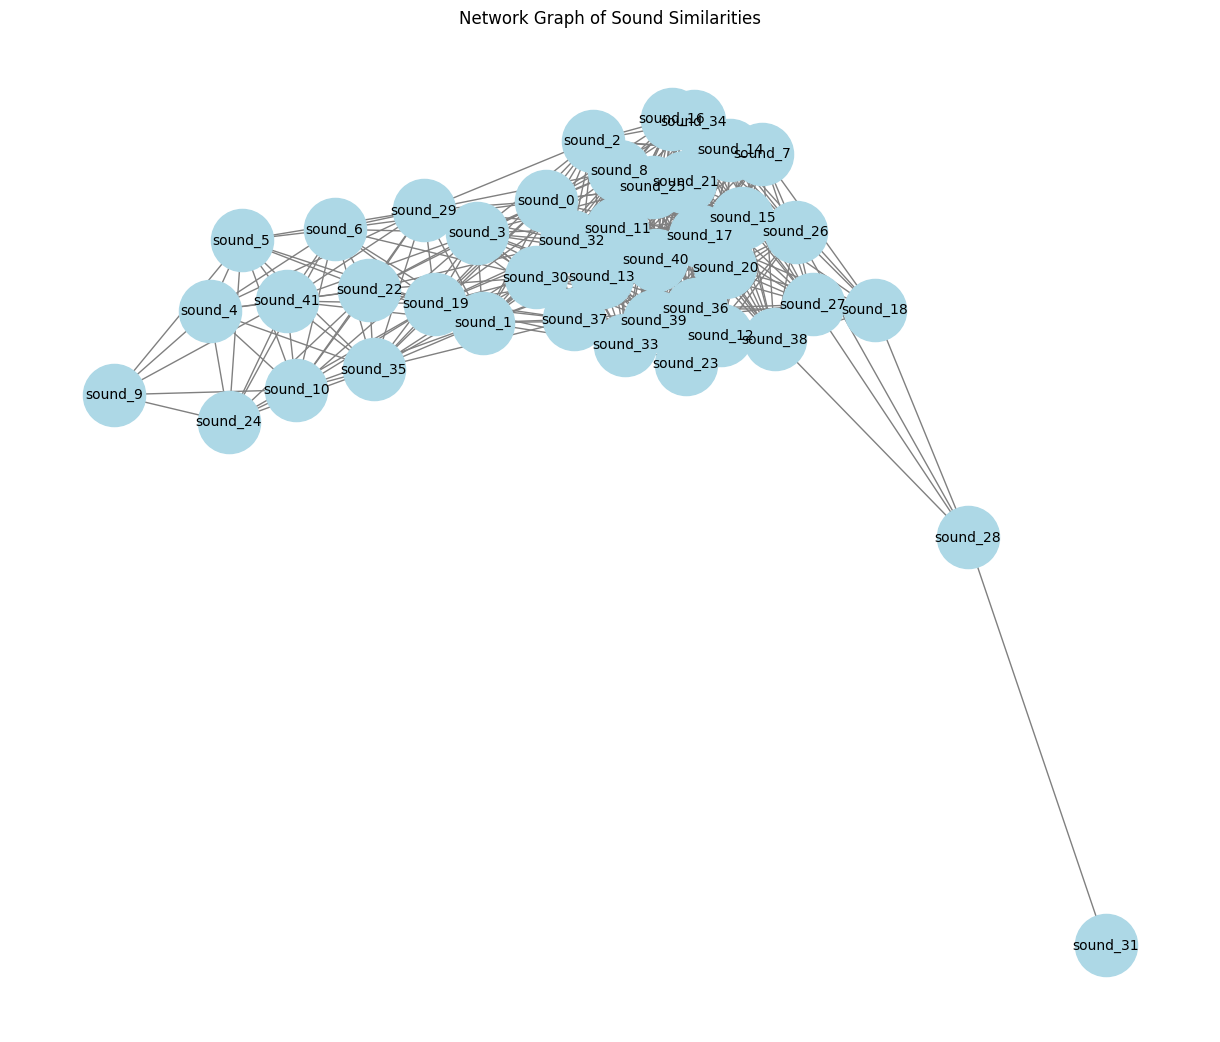

In [ ]:
import networkx as nx

# Function to create and plot a network graph based on sound similarity
def plot_network_graph(similarity_matrix, labels, threshold=0.7):
    G = nx.Graph()

    # Add nodes
    for i, label in enumerate(labels):
        G.add_node(label)

    # Add edges based on similarity threshold
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] >= threshold:
                G.add_edge(labels[i], labels[j], weight=similarity_matrix[i, j])

    pos = nx.spring_layout(G)  # Layout for a better visualization
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', font_size=10, node_size=2000, edge_color='gray')
    plt.title('Network Graph of Sound Similarities')
    plt.show()

# Plot the network graph with a similarity threshold
plot_network_graph(similarity_matrix, file_names, threshold=0.7)


In [ ]:
import soundfile as sf
import numpy as np
import librosa
import pandas as pd

# Function to extract relevant audio features using soundfile and librosa
def extract_audio_features(file_name):
    audio, sr = sf.read(file_name)  # Read audio using soundfile

    # Extract features
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)  # Tempo (BPM)
    loudness = np.mean(librosa.feature.rms(y=audio))  # Root Mean Square Energy (Loudness)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))  # Spectral Centroid (brightness)

    # Additional features can be added if needed
    return tempo, loudness, spectral_centroid

# Map features to mood categories based on thresholds
def map_to_mood(tempo, loudness, spectral_centroid):
    if tempo > 120 and loudness > 0.02:
        return 'Energetic'
    elif tempo < 80 and spectral_centroid < 2000:
        return 'Calm'
    elif loudness < 0.01:
        return 'Sad'
    else:
        return 'Happy'

# Directory containing WAV files
wav_dir = 'wav_files'

# Analyze each sound file
mood_results = []
for index, row in data.iterrows():
    wav_file = os.path.join(wav_dir, f"sound_{index}.wav")
    tempo, loudness, spectral_centroid = extract_audio_features(wav_file)
    mood = map_to_mood(tempo, loudness, spectral_centroid)
    mood_results.append({'file': f"sound_{index}", 'mood': mood, 'tempo': tempo, 'loudness': loudness, 'spectral_centroid': spectral_centroid})

# Convert results to DataFrame for analysis
mood_df = pd.DataFrame(mood_results)

# Display the results
print(mood_df)


        file       mood                 tempo  loudness  spectral_centroid
0    sound_0        Sad  [101.35135135135135]  0.002731        4428.851700
1    sound_1        Sad  [138.88888888888889]  0.005870        1302.941477
2    sound_2      Happy               [187.5]  0.010818        2039.797000
3    sound_3  Energetic  [129.31034482758622]  0.106975         977.135829
4    sound_4  Energetic  [133.92857142857142]  0.059310        1028.617326
5    sound_5        Sad  [104.16666666666667]  0.003107        2043.229496
6    sound_6        Sad  [120.96774193548387]  0.009455        3359.782116
7    sound_7        Sad               [125.0]  0.006260        2675.514387
8    sound_8  Energetic               [150.0]  0.095392        2224.727613
9    sound_9  Energetic  [138.88888888888889]  0.040240        1505.768183
10  sound_10      Happy            [117.1875]  0.056055        3773.616527
11  sound_11      Happy  [117.45383522727273]  0.075182        1388.840757
12  sound_12      Happy  

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Define mood colors
mood_colors = {
    'Energetic': 'red',
    'Calm': 'blue',
    'Sad': 'purple',
    'Happy': 'green'
}

# Initialize the map centered on New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Create a MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# Plot markers with moods
for idx, row in data.iterrows():
    location = list(map(float, row['location'].split(',')))  # Get lat/lon coordinates
    mood = mood_df.loc[idx, 'mood']  # Get the mood classification
    color = mood_colors[mood]  # Choose color based on mood

    # Add the marker to the cluster with a popup showing the reason and mood
    folium.Marker(location,
                  popup=f"Reason: {row['reason']}<br>Mood: {mood}",
                  icon=folium.Icon(color=color)).add_to(marker_cluster)

# Save the map to an HTML file and display it
m.save("nyc_mood_clustering_map.html")
m


In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Download VADER lexicon if not already installed
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment based on VADER scores
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    compound_score = sentiment_score['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Perform sentiment analysis on each reason
data['sentiment'] = data['reason'].apply(lambda reason: get_sentiment(reason))

# Display the sentiment results
print(data[['reason', 'sentiment']])


                                               reason sentiment
0   "Fun throwing wood chips at brother at playgro...  Positive
1                                             "Funny"   Neutral
2                             "Quiet moment at work."   Neutral
3      "Just riding the commuter train to church. ...  Positive
4      "The lady was complaining about the new man...  Negative
5         "This subway station has its quiet moments"   Neutral
6                             "It's my neighborhood "   Neutral
7                            "it's wear my dad works"   Neutral
8      "L train to manhattan, memorial day weekend...   Neutral
9                       "Calming sounds of chanting."  Positive
10                           "Waiting for my coffee."   Neutral
11  "An amazingly quiet japanese style garden with...  Negative
12  "Amazing sculpture that was triggered by a foo...  Positive
13     "Quiet scape from inside the museum with su...   Neutral
14     "Amazing soundscape in the middle

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
import folium
from folium.plugins import MarkerCluster

# Define sentiment colors
sentiment_colors = {
    'Positive': 'green',
    'Neutral': 'blue',
    'Negative': 'red'
}

# Initialize the map centered on New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Create a MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# Plot markers with sentiment
for idx, row in data.iterrows():
    location = list(map(float, row['location'].split(',')))  # Get lat/lon coordinates
    sentiment = row['sentiment']  # Get the sentiment
    color = sentiment_colors[sentiment]  # Choose color based on sentiment

    # Add the marker to the cluster with a popup showing the reason and sentiment
    folium.Marker(location,
                  popup=f"Reason: {row['reason']}<br>Sentiment: {sentiment}",
                  icon=folium.Icon(color=color)).add_to(marker_cluster)

# Save the map to an HTML file and display it
m.save("nyc_sentiment_analysis_map.html")
m


In [ ]:
# Merge mood classification and text sentiment classification
comparison_df = pd.DataFrame({
    'file': mood_df['file'],
    'mood': mood_df['mood'],
    'reason_sentiment': data['sentiment']
})

# Display the combined data for analysis
print(comparison_df.head())


      file       mood reason_sentiment
0  sound_0        Sad         Positive
1  sound_1        Sad          Neutral
2  sound_2      Happy          Neutral
3  sound_3  Energetic         Positive
4  sound_4  Energetic         Negative


In [ ]:
# Map mood categories to sentiment-like labels for comparison (simplified)
mood_to_sentiment = {
    'Happy': 'Positive',
    'Energetic': 'Positive',
    'Calm': 'Neutral',
    'Sad': 'Negative'
}

# Compare mood (sound) and sentiment (reason) point-by-point
comparison_df['mood_sentiment'] = comparison_df['mood'].map(mood_to_sentiment)
comparison_df['is_different'] = comparison_df['mood_sentiment'] != comparison_df['reason_sentiment']

# Display points where the mood and sentiment differ
differences = comparison_df[comparison_df['is_different']]

# Show summary of differences
print(f"Total number of points with differences: {len(differences)}")
print(differences[['file', 'mood', 'mood_sentiment', 'reason_sentiment']])


Total number of points with differences: 28
        file       mood mood_sentiment reason_sentiment
0    sound_0        Sad       Negative         Positive
1    sound_1        Sad       Negative          Neutral
2    sound_2      Happy       Positive          Neutral
4    sound_4  Energetic       Positive         Negative
5    sound_5        Sad       Negative          Neutral
6    sound_6        Sad       Negative          Neutral
7    sound_7        Sad       Negative          Neutral
8    sound_8  Energetic       Positive          Neutral
10  sound_10      Happy       Positive          Neutral
11  sound_11      Happy       Positive         Negative
13  sound_13      Happy       Positive          Neutral
15  sound_15       Calm        Neutral         Negative
18  sound_18        Sad       Negative          Neutral
19  sound_19        Sad       Negative          Neutral
22  sound_22  Energetic       Positive          Neutral
25  sound_25  Energetic       Positive          Neutral
29  

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the mood and sentiment into numeric categories
mood_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()

comparison_df['mood_encoded'] = mood_encoder.fit_transform(comparison_df['mood'])
comparison_df['sentiment_encoded'] = sentiment_encoder.fit_transform(comparison_df['reason_sentiment'])

# Calculate correlation between mood and sentiment
correlation = comparison_df['mood_encoded'].corr(comparison_df['sentiment_encoded'])

print(f"Correlation between mood and sentiment: {correlation}")


Correlation between mood and sentiment: 0.0721366118268526


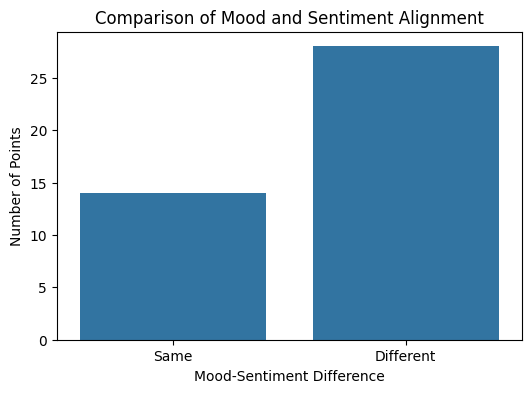

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the differences between mood and sentiment
plt.figure(figsize=(6,4))
sns.countplot(x='is_different', data=comparison_df)
plt.title('Comparison of Mood and Sentiment Alignment')
plt.xlabel('Mood-Sentiment Difference')
plt.ylabel('Number of Points')
plt.xticks([0, 1], ['Same', 'Different'])
plt.show()


## correlation calculate improve

## Step 1: Define Custom Distance Between Moods
We can create a distance matrix that reflects the difference between various mood categories. For example:

Positive and Sad have a large difference.
Positive and Neutral have a smaller difference.
Negative and Neutral also have a smaller difference.

Positive Neutral	Negative	Sad <br>
Positive	0	1	2	3<br>
Neutral	1	0	1	2<br>
Negative	2	1	0	1<br>
Sad	3	2	1	0<br>

This matrix represents the subjective "distance" between moods.



## Step 2: Compute Mood Distance for Each Point

We'll calculate the distance between the sound mood and the reason mood for each point using this matrix.

In [ ]:
import numpy as np
import pandas as pd

# Define custom distance matrix for mood differences
mood_distance_matrix = {
    'Positive': {'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Sad': 3},
    'Neutral': {'Positive': 1, 'Neutral': 0, 'Negative': 1, 'Sad': 2},
    'Negative': {'Positive': 2, 'Neutral': 1, 'Negative': 0, 'Sad': 1},
    'Sad': {'Positive': 3, 'Neutral': 2, 'Negative': 1, 'Sad': 0}
}

# Assume both sound and reason moods have been categorized (replace sentiment with mood)
comparison_df['reason_mood'] = comparison_df['reason_sentiment'].replace({
    'Positive': 'Positive',
    'Neutral': 'Neutral',
    'Negative': 'Sad'  # Adjust reason-based mood as per logic
})

# Calculate the mood distance for each point
def calculate_mood_distance(row):
    sound_mood = row['mood_sentiment']  # Mood from sound
    reason_mood = row['reason_mood']    # Mood from reason
    return mood_distance_matrix[sound_mood][reason_mood]

# Apply the distance calculation
comparison_df['mood_distance'] = comparison_df.apply(calculate_mood_distance, axis=1)

# Display the distances for review
print(comparison_df[['file', 'mood', 'reason_mood', 'mood_distance']])


        file       mood reason_mood  mood_distance
0    sound_0        Sad    Positive              2
1    sound_1        Sad     Neutral              1
2    sound_2      Happy     Neutral              1
3    sound_3  Energetic    Positive              0
4    sound_4  Energetic         Sad              3
5    sound_5        Sad     Neutral              1
6    sound_6        Sad     Neutral              1
7    sound_7        Sad     Neutral              1
8    sound_8  Energetic     Neutral              1
9    sound_9  Energetic    Positive              0
10  sound_10      Happy     Neutral              1
11  sound_11      Happy         Sad              3
12  sound_12      Happy    Positive              0
13  sound_13      Happy     Neutral              1
14  sound_14      Happy    Positive              0
15  sound_15       Calm         Sad              2
16  sound_16  Energetic    Positive              0
17  sound_17      Happy    Positive              0
18  sound_18        Sad     Neu

## Step 3: Aggregate and Analyze the Distances
We'll calculate the average mood distance to understand how different the sound moods and reason moods are overall.

In [ ]:
# Calculate the average mood distance
average_mood_distance = comparison_df['mood_distance'].mean()
print(f"Average mood distance: {average_mood_distance}")


Average mood distance: 0.9761904761904762


##Step 4: Visualize Mood Distance Distribution
We can visualize the distribution of mood distances to see how often the sound and reason moods align closely or differ significantly.

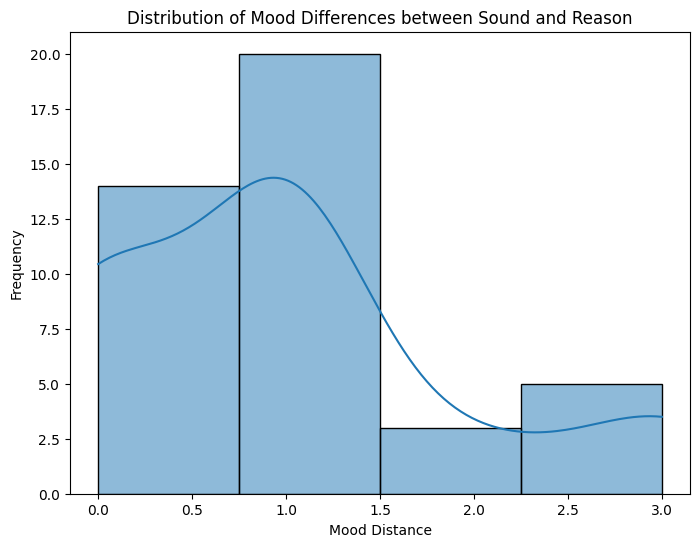

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of mood distances
plt.figure(figsize=(8, 6))
sns.histplot(comparison_df['mood_distance'], bins=4, kde=True)
plt.title('Distribution of Mood Differences between Sound and Reason')
plt.xlabel('Mood Distance')
plt.ylabel('Frequency')
plt.show()



The histogram you provided shows the distribution of mood differences between sound moods and reason moods, where the mood distance is the numeric representation of how different the moods are on a scale of 0 to 3:

1. X-Axis (Mood Distance):

- 0: Sound mood and reason mood are the same.
- 1: Sound mood and reason mood differ slightly (e.g., Positive vs. Neutral).
- 2: Sound mood and reason mood have moderate differences (e.g., Positive vs. Negative).
- 3: Sound mood and reason mood are very different (e.g., Positive vs. Sad).
2. Y-Axis (Frequency):

The number of occurrences for each mood distance value.
Interpretation of the Plot:
- Mood Distance of 0: There are about 10 occurrences where the mood derived from the sound matches exactly with the reason mood.
- Mood Distance of 1: The most common difference is a slight mismatch (distance of 1) between the sound mood and reason mood. This happens in about 20 cases.
- Mood Distance of 2: Few cases (about 5) have a moderate difference in mood, where the sound and reason differ significantly but not drastically.
- Mood Distance of 3: There are a few cases (around 3) where the sound mood and reason mood are highly divergent, such as Positive vs. Sad.

The **average mood distance** of approximately 0.98 indicates that, on average, the sound-based mood and reason-based mood are relatively close, with slight differences. A distance of 1 suggests that the two moods are typically one category apart (e.g., Positive to Neutral or Negative to Neutral), but not drastically different (like Positive vs. Sad).

**Interpretation**:

1. Low Average Mood Distance:

An average distance of around 1 suggests that for most sounds, the mood derived from the audio and the reason provided are quite aligned or only slightly different. This indicates consistency between how people perceive the mood of a sound and the mood they express in the reason.
2. Mood Consistency:

This alignment shows that sounds and reasons are generally perceived in a similar emotional context.

# Calculate Real-World Distance Between Sound Locations

We’ll use the Haversine formula to calculate the real-world distance between two geographic coordinates (latitude, longitude).

In [ ]:
import numpy as np

# Function to calculate the Haversine distance between two coordinate points (in kilometers)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Parse the coordinates and calculate the distance matrix
num_sounds = len(data)
location_coords = np.array([parse_location(loc) for loc in data['location']])

# Initialize a matrix for geographic distances
geo_distance_matrix = np.zeros((num_sounds, num_sounds))

# Calculate the geographic distance between all pairs of sounds
for i in range(num_sounds):
    for j in range(i + 1, num_sounds):
        lat1, lon1 = location_coords[i]
        lat2, lon2 = location_coords[j]
        distance = haversine(lat1, lon1, lat2, lon2)
        geo_distance_matrix[i, j] = geo_distance_matrix[j, i] = distance

# Normalize the geographic distances (optional, to scale them similarly to audio similarity)
geo_distance_matrix_normalized = geo_distance_matrix / geo_distance_matrix.max()

# Display a few values for review
print(geo_distance_matrix_normalized[:5, :5])


[[0.         0.19025499 0.48998051 0.55886791 0.57530322]
 [0.19025499 0.         0.34952283 0.42779472 0.44986629]
 [0.48998051 0.34952283 0.         0.08087002 0.10669774]
 [0.55886791 0.42779472 0.08087002 0.         0.02790158]
 [0.57530322 0.44986629 0.10669774 0.02790158 0.        ]]


# Step 2: Combine Audio Similarity and Real-World Distance
Now, we combine the audio similarity (calculated earlier) with the geographic distance. You can decide on a weighting factor to control the balance between geographic and audio similarity.

For example, if you want to give 70% weight to audio similarity and 30% to geographic proximity:

In [ ]:
# Combine audio similarity and geographic distance into a single metric
# Assuming the similarity matrix has been calculated earlier and is normalized between 0 and 1

audio_weight = 0.7  # Weight for audio similarity
geo_weight = 0.3    # Weight for geographic proximity

# Calculate the combined similarity: high audio similarity + proximity = high overall similarity
combined_similarity = audio_weight * similarity_matrix + geo_weight * (1 - geo_distance_matrix_normalized)

# Display the combined similarity matrix
print(combined_similarity[:5, :5])


[[1.         0.85651021 0.7991685  0.74164538 0.53514816]
 [0.85651021 1.         0.77635582 0.84724448 0.63398673]
 [0.7991685  0.77635582 1.         0.8617836  0.66031243]
 [0.74164538 0.84724448 0.8617836  1.         0.76151409]
 [0.53514816 0.63398673 0.66031243 0.76151409 1.        ]]


#Step 3: Visualize Combined Similarity
We can visualize the combined similarity using a heatmap and further explore the relationships:

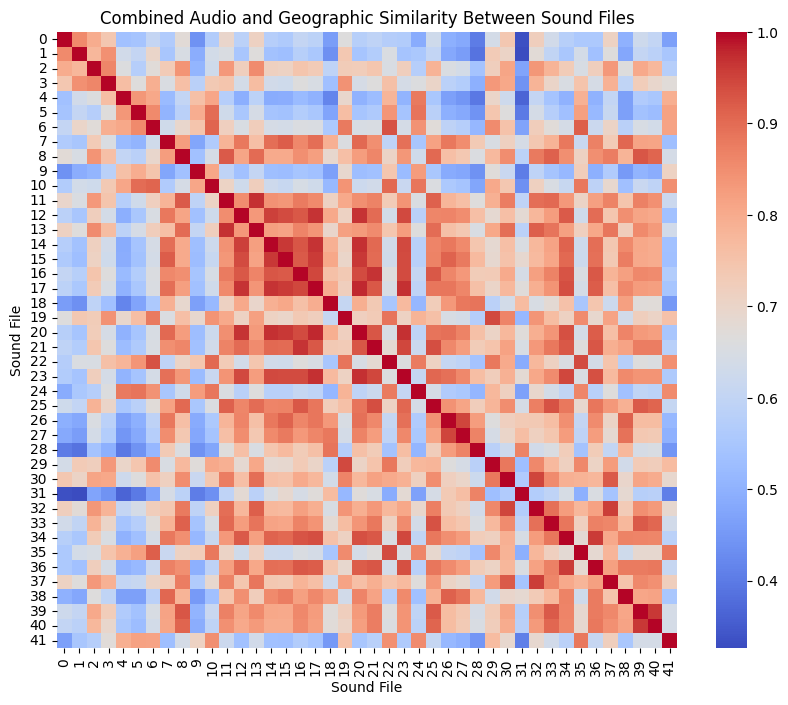

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the combined similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_similarity, cmap="coolwarm", annot=False)
plt.title('Combined Audio and Geographic Similarity Between Sound Files')
plt.xlabel('Sound File')
plt.ylabel('Sound File')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


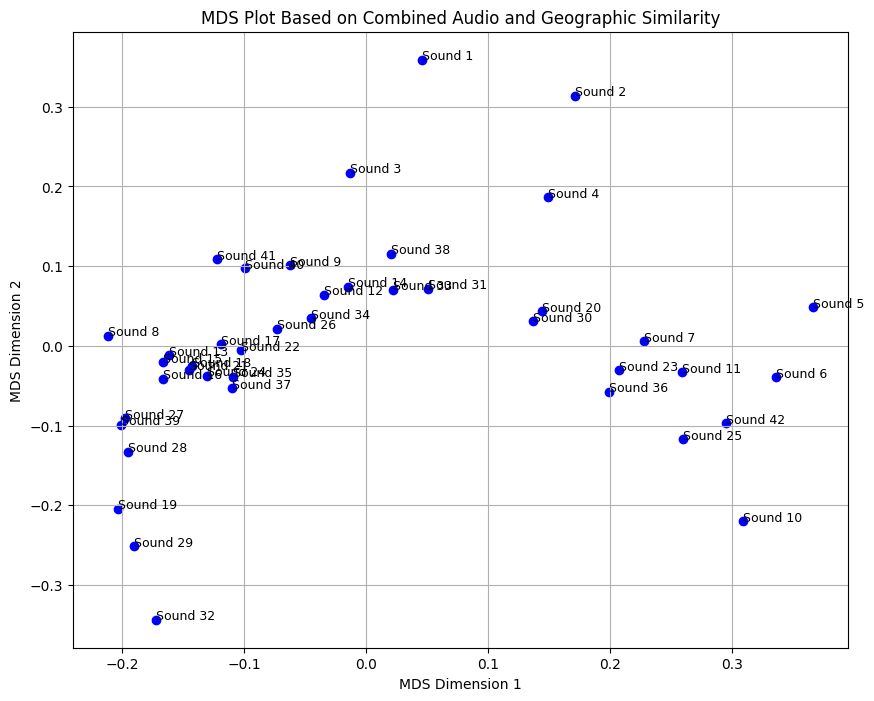

In [ ]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Perform MDS on the combined similarity matrix
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
# Since similarity is already computed, we need to convert it to a dissimilarity matrix by subtracting from 1
dissimilarity_matrix = 1 - combined_similarity
mds_result = mds.fit_transform(dissimilarity_matrix)

# Extract the X and Y coordinates from the MDS result
x_coords = mds_result[:, 0]
y_coords = mds_result[:, 1]

# Plot the MDS results
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, c='blue', marker='o')

# Annotate each point with its index or file name
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    plt.text(x, y, f"Sound {i+1}", fontsize=9)

plt.title('MDS Plot Based on Combined Audio and Geographic Similarity')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()


# Step 1: Perform Clustering on the Combined Similarity
Let’s start with Agglomerative Clustering, which can cluster the sounds based on the combined similarity (audio + geographic distance).

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Perform clustering using Agglomerative Clustering with precomputed distances
# Convert similarity to a dissimilarity matrix by subtracting from 1
dissimilarity_matrix = 1 - combined_similarity

# Use Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='average')
labels = clustering.fit_predict(dissimilarity_matrix)

# Add the cluster labels to the dataframe for further analysis
comparison_df['cluster'] = labels

# Display the first few rows with cluster labels
print(comparison_df[['file', 'mood', 'reason_mood', 'cluster']])


        file       mood reason_mood  cluster
0    sound_0        Sad    Positive        2
1    sound_1        Sad     Neutral        2
2    sound_2      Happy     Neutral        2
3    sound_3  Energetic    Positive        2
4    sound_4  Energetic         Sad        0
5    sound_5        Sad     Neutral        0
6    sound_6        Sad     Neutral        0
7    sound_7        Sad     Neutral        1
8    sound_8  Energetic     Neutral        1
9    sound_9  Energetic    Positive        0
10  sound_10      Happy     Neutral        0
11  sound_11      Happy         Sad        1
12  sound_12      Happy    Positive        1
13  sound_13      Happy     Neutral        1
14  sound_14      Happy    Positive        1
15  sound_15       Calm         Sad        1
16  sound_16  Energetic    Positive        1
17  sound_17      Happy    Positive        1
18  sound_18        Sad     Neutral        3
19  sound_19        Sad     Neutral        0
20  sound_20      Happy    Positive        1
21  sound_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


#Step 2: Visualize the Clusters on the MDS Plot
We can plot the MDS results (as done earlier) but this time color the points based on the clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


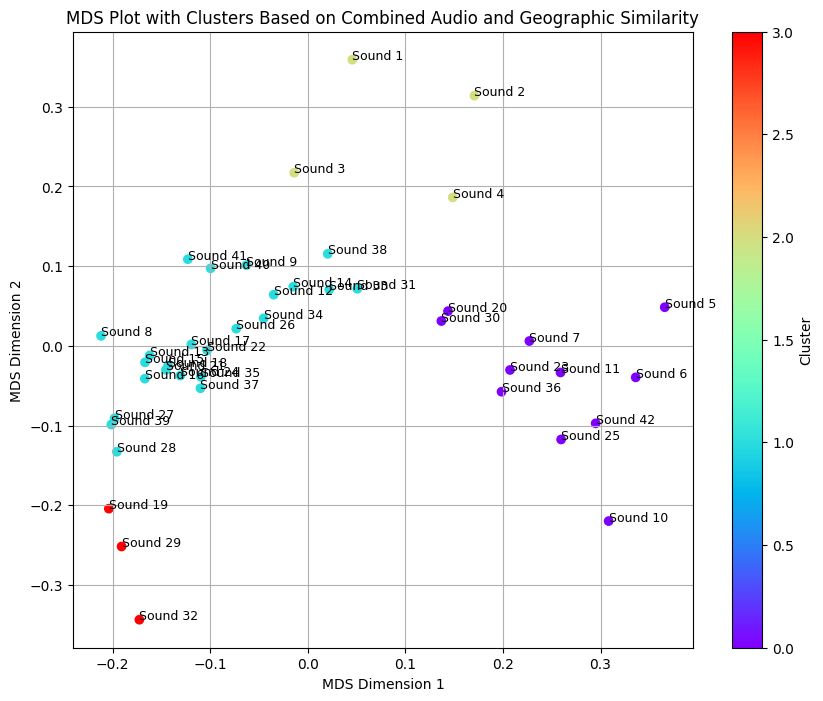

In [ ]:
# Perform MDS on the combined similarity matrix (already done before)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_result = mds.fit_transform(dissimilarity_matrix)

# Extract the X and Y coordinates from the MDS result
x_coords = mds_result[:, 0]
y_coords = mds_result[:, 1]

# Plot the MDS results, colored by cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_coords, y_coords, c=labels, cmap='rainbow', marker='o')

# Annotate each point with its index or file name
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    plt.text(x, y, f"Sound {i+1}", fontsize=9)

plt.title('MDS Plot with Clusters Based on Combined Audio and Geographic Similarity')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


In [ ]:
import folium

# Initialize the map centered on New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# List of specific sounds to label
specific_sounds = [1, 2, 32, 41]

# Define a set of colors for the clusters (for visual reference)
cluster_colors = ['red', 'green', 'blue', 'purple', 'orange', 'darkred', 'lightblue']

# Plot sound locations and label specific sounds
locations = [parse_location(loc) for loc in data['location']]

for idx, location in enumerate(locations):
    cluster_label = labels[idx]
    color = cluster_colors[cluster_label % len(cluster_colors)]  # Assign colors to each cluster

    # Add marker with label for specific sounds
    if idx + 1 in specific_sounds:  # We use `idx + 1` because sound numbers are 1-based
        folium.Marker(
            location,
            popup=f"Sound {idx+1}<br>Cluster: {cluster_label}",
            icon=folium.Icon(color='orange', icon="info-sign")
        ).add_to(m)
    else:
        # Add other points normally
        folium.Marker(
            location,
            popup=f"Sound {idx+1}<br>Cluster: {cluster_label}",
            icon=folium.Icon(color=color)
        ).add_to(m)

# Save and display the map
m.save("nyc_clustered_sound_labeled_map.html")
m


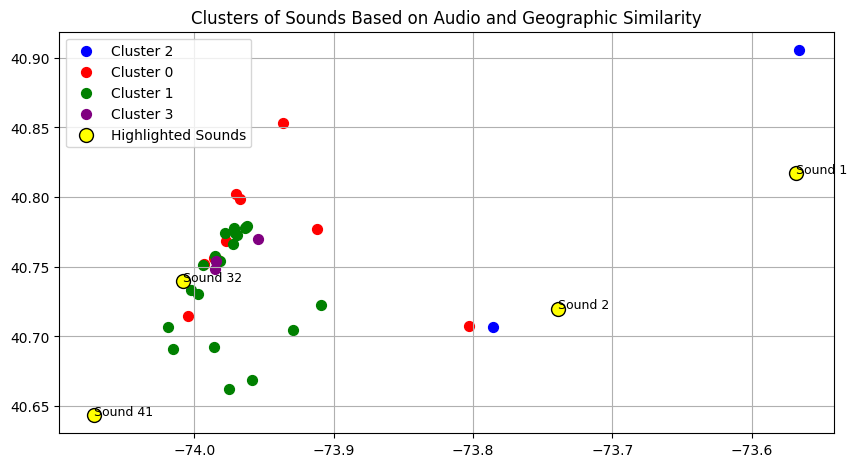

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Create a GeoDataFrame with the sound locations and clusters
gdf = gpd.GeoDataFrame(comparison_df,
                       geometry=gpd.points_from_xy(data['location'].apply(lambda x: float(x.split(',')[1])),
                                                   data['location'].apply(lambda x: float(x.split(',')[0]))))

# Define a set of colors for the clusters
cluster_colors = ['red', 'green', 'blue', 'purple', 'orange', 'darkred', 'lightblue']

# Create a column to store the color based on the cluster
gdf['color'] = gdf['cluster'].apply(lambda x: cluster_colors[x % len(cluster_colors)])

# Plot the clusters using GeoPandas
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each cluster with its respective color
for cluster_label in gdf['cluster'].unique():
    cluster_gdf = gdf[gdf['cluster'] == cluster_label]
    cluster_gdf.plot(ax=ax, color=cluster_gdf['color'].values[0], markersize=50, label=f'Cluster {cluster_label}')

# Highlight specific sounds (1, 2, 32, 41)
specific_sounds = [1, 2, 32, 41]
highlighted_gdf = gdf[gdf['file'].apply(lambda x: int(x.split('_')[1]) in specific_sounds)]

# Plot specific sounds with black border
highlighted_gdf.plot(ax=ax, color='yellow', edgecolor='black', markersize=100, label="Highlighted Sounds")

# Add labels to the highlighted sounds
for idx, row in highlighted_gdf.iterrows():
    plt.text(row.geometry.x, row.geometry.y, f"Sound {int(row['file'].split('_')[1])}", fontsize=9)

# Customize plot
plt.title("Clusters of Sounds Based on Audio and Geographic Similarity")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


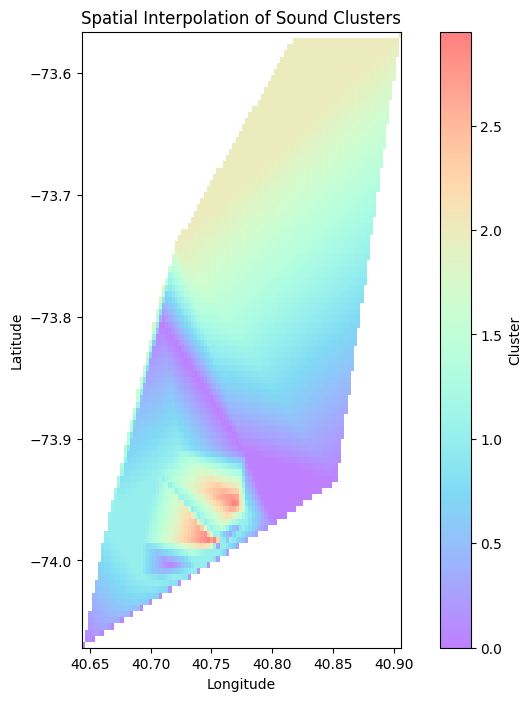

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder

# Create a GeoDataFrame from the sound data with coordinates
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['location'].apply(lambda x: float(x.split(', ')[1])),
                                                         data['location'].apply(lambda x: float(x.split(', ')[0]))))

# Extract coordinates and cluster labels for interpolation
coords = np.array([parse_location(loc) for loc in data['location']])
labels = clustering.labels_  # Assuming `labels` contains cluster labels

# Create a grid of points to interpolate on
grid_x, grid_y = np.mgrid[coords[:, 0].min():coords[:, 0].max():100j,
                          coords[:, 1].min():coords[:, 1].max():100j]

# Perform Inverse Distance Weighting (IDW) interpolation
grid_z = griddata(coords, labels, (grid_x, grid_y), method='linear')

# Plot the interpolated clusters using GeoPandas and Matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='black', markersize=5)  # Plot the original sound points

# Plot the interpolated surface
plt.imshow(grid_z.T, extent=(coords[:, 0].min(), coords[:, 0].max(),
                             coords[:, 1].min(), coords[:, 1].max()),
           origin='lower', cmap='rainbow', alpha=0.5)

plt.colorbar(label='Cluster')
plt.title('Spatial Interpolation of Sound Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
